In [1]:
# import lib
import numpy as np
from scipy import stats
from collections import Counter
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn import preprocessing
import sklearn.discriminant_analysis as da
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import random
from datetime import datetime
%matplotlib inline

In [2]:
listings_df = pd.read_csv('listings.csv', header = 0)

In [ ]:
print 'shape:', listings_df.shape

missing_v = []
for i in listings_df.columns:
    missing_v.append((listings_df.shape[0] - listings_df[i].count()))
    
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(missing_v, bins = 60)
plt.show()

# thus we delete the lowest 3
for i in listings_df.columns:
    if listings_df.shape[0] - listings_df[i].count() > 5000:
        print i
        
# thus we drop that three, not very useful, just discount

# which is much smaller than 27392, so it is not useful, thus we delete it
listings_modified1 = listings_df.drop(['square_feet','weekly_price','monthly_price', 'first_review', 'last_review'], axis = 1)

In [4]:
listings_modified2 = listings_modified1.drop(['country','state','market'], axis = 1)
# picture_url, host_id, host_picture_url, neighbourhood
# host_names, host_since, street, zipcode, calendar_updated, calendar_last_scraped
listings_modified3 = listings_modified2.drop(['picture_url', 'host_id','host_picture_url', 
                                              'host_name', 'host_since','street', 'zipcode', 
                                              'calendar_updated', 'calendar_last_scraped',
                                              'neighbourhood', 'scrape_id', 'last_scraped'], axis = 1)

In [ ]:
# clean up prices, delete dollar sign
prices_tmp = listings_modified3.price
extra_tmp = listings_modified3.extra_people

prices = []
extra = []
# delete all ,
for i in prices_tmp:
    prices.append(i.replace(',', ''))
    
for i in extra_tmp:
    extra.append(i.replace(',', ''))

prices = [float(i[1:]) for i in prices]
extra = [float(i[1:]) for i in extra]

price_1 = np.percentile(prices, 25)
price_2 = np.percentile(prices, 50)
price_3 = np.percentile(prices, 75)
price_high = np.percentile(prices, 95)

# visualize price distribution
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(prices, alpha = 0.4, bins = 120)
ax.set_xlim(0,3500)
ax.set_ylabel('frequency')
ax.set_xlabel('price')
ax.axvline(x = price_1, color = 'r', linewidth=1)
ax.axvline(x = price_2,  color = 'r', linewidth=1)
ax.axvline(x = price_3,  color = 'r', linewidth=1)
ax.axvline(x = price_high, color = 'b', linewidth=1)
plt.show()

# we see a lot outliers

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(prices, alpha = 0.4, bins = 400)
ax.set_xlim(0,700)
ax.set_ylabel('frequency')
ax.set_xlabel('price')
ax.axvline(x = price_1, color = 'r', linewidth=1)
ax.axvline(x = price_2,  color = 'r', linewidth=1)
ax.axvline(x = price_3,  color = 'r', linewidth=1)
ax.axvline(x = price_high, color = 'b', linewidth=1)
plt.show()


# # drop the old $ price and replace with float
listings_modified4 = listings_modified3.drop(['price', 'extra_people'], axis = 1)
listings_modified4['price'] = prices
listings_modified4['extra_people'] = extra
listings_modified4.head()

In [8]:
listings_modified4 = listings_modified4[listings_modified4['price'] <= price_high]
len(listings_modified4)
listings_modified4

,id,name,neighbourhood_cleansed,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price,extra_people
0,1069266,Stay like a real New Yorker!,Midtown East,New York,40.756852,-73.964754,t,Apartment,Entire home/apt,2,...,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160.0,0.0
1,1846722,Apartment 20 Minutes Times Square,Hamilton Heights,New York,40.830599,-73.941014,f,Apartment,Entire home/apt,10,...,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,105.0,50.0
2,2061725,Option of 2 Beds w Private Bathroom,Bushwick,Brooklyn,40.692189,-73.924120,t,Apartment,Private room,2,...,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58.0,12.0
3,44974,Charming Bright West Village Studio,West Village,New York,40.734751,-74.002592,t,Apartment,Entire home/apt,2,...,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185.0,0.0
4,4701675,Charming Apartment in Chelsea,Chelsea,New York,40.745282,-73.997836,t,Apartment,Entire home/apt,2,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195.0,0.0
5,68914,Calm & Sunny Apt in Carroll Gardens,Carroll Gardens,Brooklyn,40.679060,-73.994730,t,Apartment,Entire home/apt,6,...,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,165.0,15.0
6,4832596,Large furnished sunny room,Bushwick,Brooklyn,40.684422,-73.909882,t,Apartment,Private room,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,80.0,0.0
7,2562510,2 br Private Room in LI/Chinatown,Chinatown,New York,40.719319,-73.997247,t,Apartment,Private room,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,120.0,0.0
8,3005360,Hip Luxury in the East Village 2BD,East Village,New York,40.726022,-73.986418,t,Apartment,Entire home/apt,4,...,96.0,10.0,9.0,9.0,10.0,10.0,9.0,4,150.0,20.0
9,2431607,Bright Airy Room for 2,Bedford-Stuyvesant,Brooklyn,40.686420,-73.934402,t,Apartment,Shared room,2,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,4,40.0,36.0


In [9]:
listings_modified4.index = range(0, len(listings_modified4))

In [36]:
listings_modified4.columns

Index([u'id', u'name', u'neighbourhood_cleansed', u'city', u'latitude',
       u'longitude', u'is_location_exact', u'property_type', u'room_type',
       u'accommodates', u'bathrooms', u'bedrooms', u'beds', u'bed_type',
       u'guests_included', u'minimum_nights', u'maximum_nights',
       u'availability_30', u'availability_60', u'availability_90',
       u'availability_365', u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value',
       u'host_listing_count', u'price', u'extra_people'],
      dtype='object')

In [11]:
# standardize longitude and latitude
min_max_scaler = preprocessing.MinMaxScaler()
x_transformed = min_max_scaler.fit_transform(listings_modified4.latitude.values)
min_max_scaler = preprocessing.MinMaxScaler()
y_transformed = min_max_scaler.fit_transform(listings_modified4.longitude.values)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [12]:
# fill missing values by randomly sampling observed values
def fill_by_sampling(df_input):
    df = df_input.copy()
    for col in df.columns:
        for i in range(len(df[col])):
            if pd.isnull(df[col].values[i]):
                df.set_value(i, col, random.choice(df[col].dropna().values))
    return df

# fill in values
df_filled_random = fill_by_sampling(listings_modified4)
df_filled_random.shape

(26024, 32)

In [13]:
# drop "city", "latitude","longitude" because they're correlated with neighborhood
df_filled_random2 = df_filled_random.drop(['city','latitude','longitude','name'], axis = 1)

In [30]:
df_filled_random2.columns

Index([u'id', u'neighbourhood_cleansed', u'is_location_exact',
       u'property_type', u'room_type', u'accommodates', u'bathrooms',
       u'bedrooms', u'beds', u'bed_type', u'guests_included',
       u'minimum_nights', u'maximum_nights', u'availability_30',
       u'availability_60', u'availability_90', u'availability_365',
       u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value',
       u'host_listing_count', u'price', u'extra_people'],
      dtype='object')

In [53]:
# neighborhood
le = preprocessing.LabelEncoder()
le.fit(df_filled_random2.neighbourhood_cleansed.values)
neigh_transformed = le.transform(df_filled_random2.neighbourhood_cleansed.values)

# location exact
le = preprocessing.LabelEncoder()
le.fit(df_filled_random2.is_location_exact.values)
location_exact_transformed = le.transform(df_filled_random2.is_location_exact.values)

# property type
le = preprocessing.LabelEncoder()
le.fit(df_filled_random2.property_type.values)
property_type_transformed = le.transform(df_filled_random2.property_type.values)

# bed type
le = preprocessing.LabelEncoder()
le.fit(df_filled_random2.bed_type.values)
bed_type_transformed = le.transform(df_filled_random2.bed_type.values)

# room type
le = preprocessing.LabelEncoder()
le.fit(df_filled_random2.room_type.values)
room_type_transformed = le.transform(df_filled_random2.room_type.values)

In [54]:
# drop categorical columns and append the above
df_filled_random3 = df_filled_random2.drop(['neighbourhood_cleansed', 'is_location_exact', 'property_type', 'bed_type', 'room_type'], axis=1)
df_filled_random3['neigh_transformed'] =neigh_transformed
df_filled_random3['location_exact_transformed'] =location_exact_transformed
df_filled_random3['property_type_transformed'] =property_type_transformed
df_filled_random3['bed_type_transformed'] =bed_type_transformed
df_filled_random3['room_type_transformed'] =room_type_transformed


In [55]:
# transform all categorical values 
x_df

,room_type,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,...,review_scores_location,review_scores_value,host_listing_count,extra_people,neigh_transformed,location_exact_transformed,property_type_transformed,bed_type_transformed,x_transformed,y_transformed
0,Entire home/apt,2,1.0,1.0,1.0,2,3,14,21,51,...,10.0,9.0,1,0.0,111,1,0,4,0.621064,0.535822
1,Entire home/apt,10,1.0,3.0,3.0,1,1,180,28,58,...,7.0,8.0,2,50.0,80,0,0,4,0.806315,0.582114
2,Private room,2,1.0,1.0,2.0,1,3,30,4,13,...,9.0,10.0,4,12.0,20,1,0,4,0.458632,0.615057
3,Entire home/apt,2,1.0,1.0,1.0,1,10,30,1,1,...,10.0,9.0,1,0.0,175,1,0,4,0.565547,0.462039
4,Entire home/apt,2,1.0,1.0,2.0,1,1,1125,30,60,...,10.0,10.0,1,0.0,25,1,0,4,0.591999,0.471313
5,Entire home/apt,6,1.0,2.0,3.0,2,2,365,11,33,...,10.0,9.0,2,15.0,22,1,0,4,0.425651,0.477369
6,Private room,2,1.0,1.0,1.0,1,1,1125,29,59,...,9.0,10.0,1,0.0,20,1,0,4,0.439121,0.642821
7,Private room,2,1.0,1.0,1.0,1,2,1125,5,5,...,10.0,9.0,1,0.0,26,1,0,4,0.526783,0.472462
8,Entire home/apt,4,1.0,2.0,2.0,2,1,1125,30,60,...,10.0,9.0,4,20.0,52,1,0,4,0.543620,0.493578
9,Shared room,2,1.0,1.0,1.0,1,4,30,0,30,...,9.0,9.0,4,36.0,10,1,0,4,0.444140,0.595008


In [56]:
# isolate x and y
y_df = df_filled_random2['price']
# drop id, that shouldn't be a predictor
x_df = df_filled_random2.drop(['price','id'], axis = 1)

X = x_df.values
y = y_df.values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
x_df.shape

(26024, 26)

In [100]:
# apply tree-based models 
# we split them up into 5 intervals, so intervals are small but still allow us to retain accuracy
price_1 = np.percentile(df_filled_random3.price, 20)
price_2 = np.percentile(df_filled_random3.price, 40)
price_3 = np.percentile(df_filled_random3.price, 60)
price_4 = np.percentile(df_filled_random3.price, 80)


# 5 dfs
df_class1 = df_filled_random3[df_filled_random3['price'] <= price_1]
df_class2 = df_filled_random3[(df_filled_random3['price'] > price_1) & (df_filled_random3['price'] <= price_2)]
df_class3 = df_filled_random3[(df_filled_random3['price'] > price_2) & (df_filled_random3['price'] <= price_3)]
df_class4 = df_filled_random3[(df_filled_random3['price'] > price_3) & (df_filled_random3['price'] <= price_4)]
df_class5 = df_filled_random3[(df_filled_random3['price'] > price_4)]

# make a new DF with new classes
df_new = df_filled_random3.copy()
df_new['price_tag'] = np.zeros(len(df_filled_random3.price))

# set

def set_price_dummy(df, num):
    for i in df['id'].values:
        df_new.set_value(df_new.loc[df_new['id'] == i].index, 'price_tag', num)
        
set_price_dummy(df_class1, 1)
set_price_dummy(df_class2, 2)
set_price_dummy(df_class3, 3)
set_price_dummy(df_class4, 4)
set_price_dummy(df_class5, 5)

# drop and save price
dropped_price = df_new.price
df_new1 = df_new.drop('price', axis=1)
y_df = df_new1['price_tag']
x_df = df_new1.drop(['id','price_tag'], axis=1)

x_df['x_transformed'] = x_transformed
x_df['y_transformed'] = y_transformed

# turn the set into train and test
# get X and Y
X = x_df.values
y = y_df.values

# test and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [85]:
# get our models
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==1], y_test[y_test==1]),
                                                 model.score(x_test[y_test==2], y_test[y_test==2]),
                                                 model.score(x_test[y_test==3], y_test[y_test==3]),
                                                 model.score(x_test[y_test==4], y_test[y_test==4]),
                                                 model.score(x_test[y_test==5], y_test[y_test==5])], 
                                                index=['overall accuracy', 'accuracy on class 1',
                                                      'accuracy on class 2', 'accuracy on class 3', 'accuracy on class 4',
                                                      'accuracy on class 5'])


#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)

# #QDA
# qda = QDA()
# qda.fit(x_train, y_train)
# qda_scores = score(qda, x_test, y_test)

#Decision Tree
tree = DecisionTree(max_depth=3)
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


#Score Dataframe
score_df = pd.DataFrame({'lda': lda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores })
score_df

,lda,rf,tree
overall accuracy,0.466445,0.483350,0.445312
accuracy on class 1,0.648310,0.749687,0.797872
accuracy on class 2,0.410480,0.363693,0.304429
accuracy on class 3,0.431026,0.464341,0.284748
accuracy on class 4,0.394126,0.354508,0.489754
accuracy on class 5,0.444354,0.476268,0.368249


In [105]:
x_df.columns

Index([u'accommodates', u'bathrooms', u'bedrooms', u'beds', u'guests_included',
       u'minimum_nights', u'maximum_nights', u'availability_30',
       u'availability_60', u'availability_90', u'availability_365',
       u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value',
       u'host_listing_count', u'extra_people', u'neigh_transformed',
       u'location_exact_transformed', u'property_type_transformed',
       u'bed_type_transformed', u'room_type_transformed', u'x_transformed',
       u'y_transformed'],
      dtype='object')

In [103]:
# tune RF with CV
n_trees = np.arange(80, 140, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(7, 14)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train[validation_indices]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            model = RandomForest(n_estimators=trees, max_depth=depth)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        average_score = np.mean(scores)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth

# Fit model on entire train set using chosen number of trees and depth
model = RandomForest(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_train, y_train)

print 'Chosen number of trees, depth:', best_trees, ',', best_depth

5-fold cross validation:
Trees: 80 Depth: 7 Score: 0.513229573098
Trees: 80 Depth: 8 Score: 0.513394784759
Trees: 80 Depth: 9 Score: 0.523331589717
Trees: 80 Depth: 10 Score: 0.526625397398
Trees: 80 Depth: 11 Score: 0.529424534308
Trees: 80 Depth: 12 Score: 0.532938468524
Trees: 80 Depth: 13 Score: 0.532059559361
Trees: 100 Depth: 7 Score: 0.50839956514
Trees: 100 Depth: 8 Score: 0.516633496777
Trees: 100 Depth: 9 Score: 0.520531639253
Trees: 100 Depth: 10 Score: 0.528271547949
Trees: 100 Depth: 11 Score: 0.530357589989
Trees: 100 Depth: 12 Score: 0.532389395117
Trees: 100 Depth: 13 Score: 0.530906512738
Trees: 120 Depth: 7 Score: 0.510539678369
Trees: 120 Depth: 8 Score: 0.516084589094
Trees: 120 Depth: 9 Score: 0.523440515516
Trees: 120 Depth: 10 Score: 0.526679468587
Trees: 120 Depth: 11 Score: 0.527613473413
Trees: 120 Depth: 12 Score: 0.533102068144
Trees: 120 Depth: 13 Score: 0.528985411175
Chosen number of trees, depth: 120 , 12


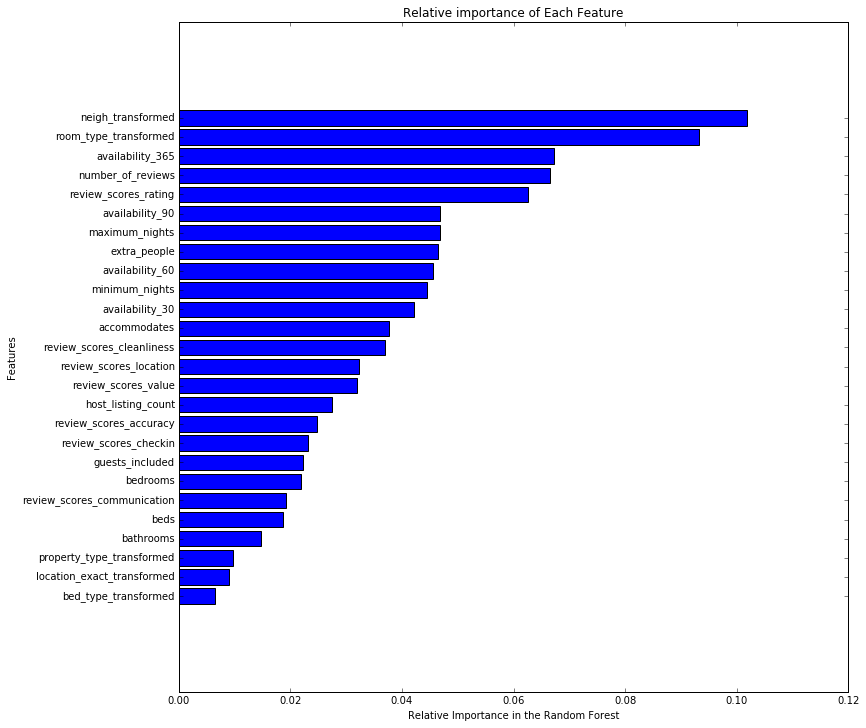

In [96]:
# random forest feature importance for model with census code
importance_list = rf.feature_importances_
name_list = x_df.columns
unicode_name_list = [unicode(i, "utf-8") for i in name_list]
importance_list, name_list = zip(*sorted(zip(importance_list, unicode_name_list)))
plt.figure(figsize=(12, 12))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

x,y and transformed_neighborhood all there

In [88]:
# drop and save price
dropped_price = df_new.price
df_new1 = df_new.drop('price', axis=1)
y_df = df_new1['price_tag']
x_df = df_new1.drop(['id','price_tag'], axis=1)

x_df['x_transformed'] = x_transformed
x_df['y_transformed'] = y_transformed

x_df2 = x_df.drop(['neigh_transformed'], axis = 1)

# turn the set into train and test
# get X and Y
X = x_df2.values
y = y_df.values

# test and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [89]:
# get our models
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==1], y_test[y_test==1]),
                                                 model.score(x_test[y_test==2], y_test[y_test==2]),
                                                 model.score(x_test[y_test==3], y_test[y_test==3]),
                                                 model.score(x_test[y_test==4], y_test[y_test==4]),
                                                 model.score(x_test[y_test==5], y_test[y_test==5])], 
                                                index=['overall accuracy', 'accuracy on class 1',
                                                      'accuracy on class 2', 'accuracy on class 3', 'accuracy on class 4',
                                                      'accuracy on class 5'])

#LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_scores = score(lda, x_test, y_test)

#Decision Tree
tree = DecisionTree(max_depth=3)
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)

#Score Dataframe
score_df = pd.DataFrame({'lda': lda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores })
score_df

,lda,rf,tree
overall accuracy,0.465420,0.479764,0.441726
accuracy on class 1,0.663924,0.749367,0.805063
accuracy on class 2,0.402314,0.357969,0.303342
accuracy on class 3,0.410363,0.455959,0.380829
accuracy on class 4,0.416107,0.353020,0.000000
accuracy on class 5,0.436901,0.478435,0.774760


In [102]:
# tune rf
# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train[validation_indices]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            model = RandomForest(n_estimators=trees, max_depth=depth)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        average_score = np.mean(scores)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth

# Fit model on entire train set using chosen number of trees and depth
model = RandomForest(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_train, y_train)

print 'Chosen number of trees, depth:', best_trees, ',', best_depth

5-fold cross validation:
Trees: 80 Depth: 7 Score: 0.507191226999
Trees: 80 Depth: 8 Score: 0.515920853882
Trees: 80 Depth: 9 Score: 0.518994459699
Trees: 80 Depth: 10 Score: 0.527996822922
Trees: 80 Depth: 11 Score: 0.532498727692
Trees: 80 Depth: 12 Score: 0.5309077632
Trees: 80 Depth: 13 Score: 0.532883463256
Trees: 100 Depth: 7 Score: 0.508399158364
Trees: 100 Depth: 8 Score: 0.516524480584
Trees: 100 Depth: 9 Score: 0.519871862282
Trees: 100 Depth: 10 Score: 0.525472215183
Trees: 100 Depth: 11 Score: 0.526898781568
Trees: 100 Depth: 12 Score: 0.531511058454
Trees: 100 Depth: 13 Score: 0.531840351841
Trees: 120 Depth: 7 Score: 0.509222670547
Trees: 120 Depth: 8 Score: 0.517182449658
Trees: 120 Depth: 9 Score: 0.522891818753
Trees: 120 Depth: 10 Score: 0.528381437959
Trees: 120 Depth: 11 Score: 0.530028673248
Trees: 120 Depth: 12 Score: 0.532553974014
Trees: 120 Depth: 13 Score: 0.530138683785
Chosen number of trees, depth: 100 , 13


For the model that uses x-transformed, y_transformed to represent location and omits neighborhood


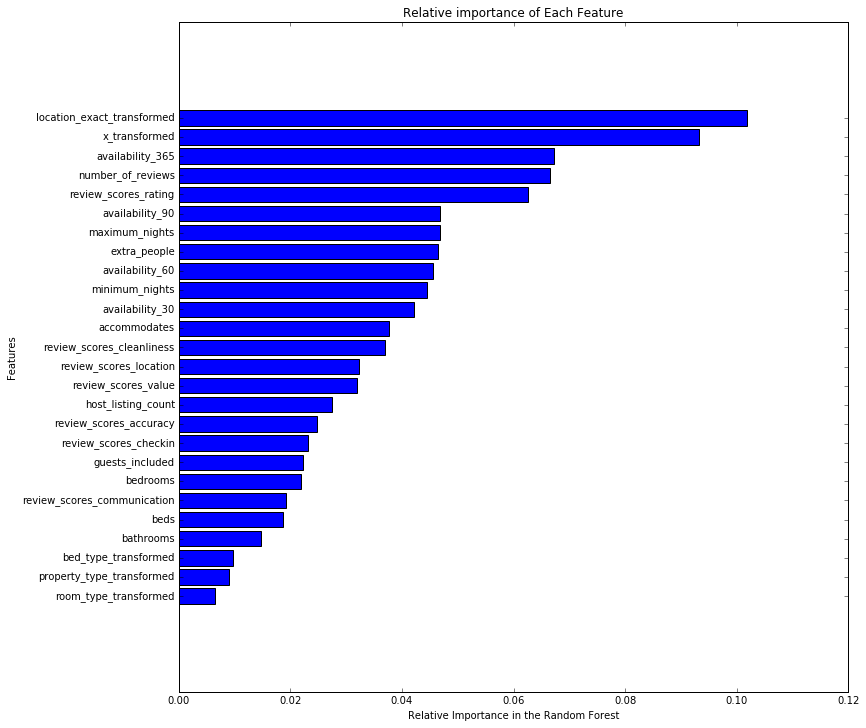

In [97]:
# random forest feature importance for model with census code
print 'For the model that uses x-transformed, y_transformed to represent location and omits neighborhood'
importance_list = rf.feature_importances_
name_list = x_df2.columns
unicode_name_list = [unicode(i, "utf-8") for i in name_list]
importance_list, name_list = zip(*sorted(zip(importance_list, unicode_name_list)))
plt.figure(figsize=(12,12))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

only x and y, dropped transformed_neigh

In [72]:
x_df2.columns

Index([u'accommodates', u'bathrooms', u'bedrooms', u'beds', u'guests_included',
       u'minimum_nights', u'maximum_nights', u'availability_30',
       u'availability_60', u'availability_90', u'availability_365',
       u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value',
       u'host_listing_count', u'extra_people', u'location_exact_transformed',
       u'property_type_transformed', u'bed_type_transformed',
       u'room_type_transformed', u'x_transformed', u'y_transformed'],
      dtype='object')

In [91]:
# drop and save price
dropped_price = df_new.price
df_new1 = df_new.drop('price', axis=1)
y_df = df_new1['price_tag']
x_df3 = df_new1.drop(['id','price_tag'], axis=1)
# turn the set into train and test
# get X and Y
X = x_df3.values
y = y_df.values

# test and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [92]:
# get our models
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==1], y_test[y_test==1]),
                                                 model.score(x_test[y_test==2], y_test[y_test==2]),
                                                 model.score(x_test[y_test==3], y_test[y_test==3]),
                                                 model.score(x_test[y_test==4], y_test[y_test==4]),
                                                 model.score(x_test[y_test==5], y_test[y_test==5])], 
                                                index=['overall accuracy', 'accuracy on class 1',
                                                      'accuracy on class 2', 'accuracy on class 3', 'accuracy on class 4',
                                                      'accuracy on class 5'])

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)

#Decision Tree
tree = DecisionTree(max_depth=3)
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)


#Score Dataframe
score_df = pd.DataFrame({'lda': lda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores })
score_df

,lda,rf,tree
overall accuracy,0.423028,0.426870,0.414575
accuracy on class 1,0.642595,0.695838,0.869645
accuracy on class 2,0.359223,0.320388,0.128803
accuracy on class 3,0.342356,0.367920,0.332832
accuracy on class 4,0.341581,0.302405,0.516838
accuracy on class 5,0.439355,0.446989,0.170483


For the model that only uses neighborhood, dropped x and y


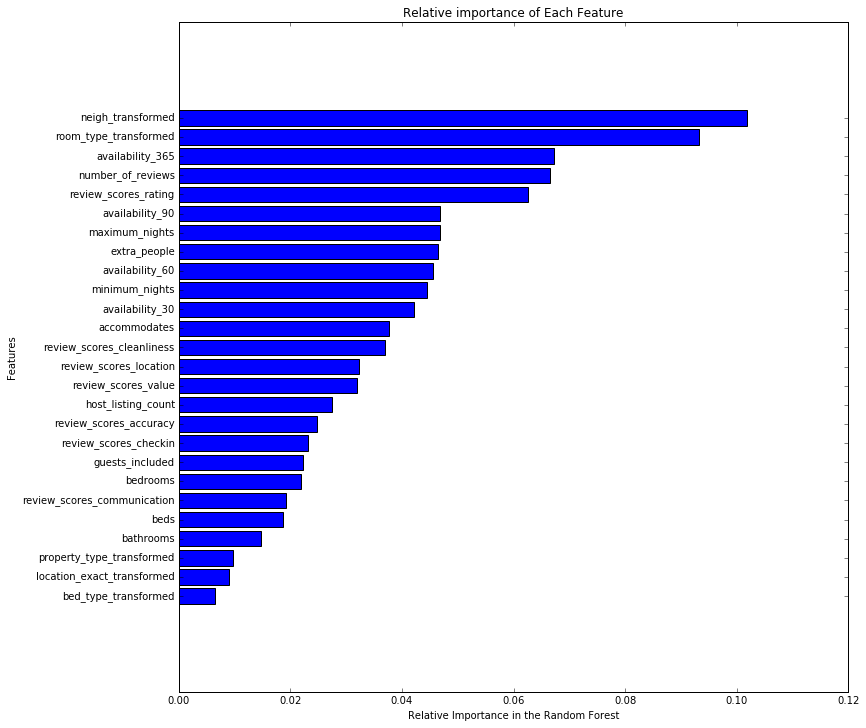

In [98]:
# random forest feature importance for model with census code
print 'For the model that only uses neighborhood, dropped x and y'
importance_list = rf.feature_importances_
name_list = x_df3.columns
unicode_name_list = [unicode(i, "utf-8") for i in name_list]
importance_list, name_list = zip(*sorted(zip(importance_list, unicode_name_list)))
plt.figure(figsize=(12, 12))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()